In this project, the variational principle was applied to solve the Schrödinger equation, numerically.

In [340]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize

pol = np.polynomial.polynomial
E = (np.pi ** 2) / 4

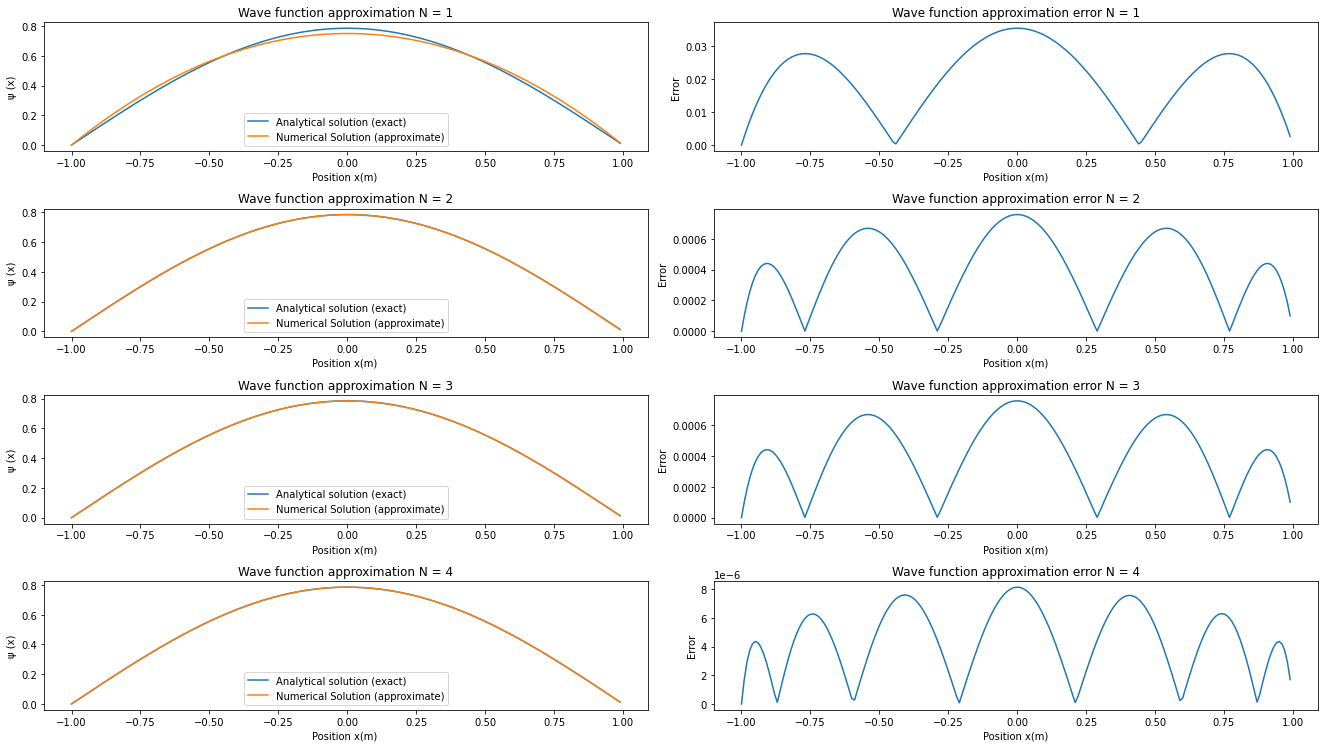

In [341]:
#Analytic solution
def exact_solution(x):
    return np.cos(x * np.pi / 2)


#Function that computes the polynomial pairs
def get_polynomials(N):
    pols = []
    for n in range(N + 1):
        #First and second term in the product of the basis function
        p1 = pol.Polynomial.basis(N - n + 1)
        p2 = pol.Polynomial.basis(n + 1)
        
        pols.append([p1, p2])
    
    return pols


#A trial wave function with custom coefficients
def trial_wave(x, coefficient_list, N):
    pols = get_polynomials(N)
    
    #Multiply evaluated polynomials and scale them by coefficients and add
    return sum([pols[i][0](1 - x) * pols[i][1](x + 1) * coefficient_list[i] for i in range(N + 1)])
    

#Function to compute second derivative of the wave function
#The formula was derived on pencli and paper d^2/dx^2 (p1(1 - x)*p2(x + 1))
#(p1(1 - x) * p2(x + 1))'' = p1''(1 - x) * p2(x+1) + p1(1 - x)* p2''(x + 1) - 2 * p1'(1-x)*p2'(x+1)
def compute_derivative(pol1, pol2, x):
    pol1_d1 = pol1.deriv()
    pol2_d1 = pol2.deriv()
    pol1_d2 = pol1.deriv(2)
    pol2_d2 = pol2.deriv(2)
    
    term1 = pol1_d2(1 - x) * pol2(x + 1)
    term2 = pol1(1 - x) * pol2_d2(x + 1)
    term3 = pol1_d1(1 - x) * pol2_d1(x + 1)
    
    return term1 + term2 - 2 * term3

    
#Get 2nd derivative of wave function
def trial_wave_d2(x, coefficient_list, N):
    pols = get_polynomials(N)
    
    #Compute derivatives of polynomials and add them together and scale by coefficients
    return sum([compute_derivative(pols[n][0], pols[n][1], x) * coefficient_list[n] for n in range(N + 1)])


#Function that performs integration needed for minimization
def integration(coefficient_list, N):
    f_numerator = lambda x: trial_wave_d2(x, coefficient_list, N) * trial_wave(x, coefficient_list, N)
    f_denominator = lambda x: trial_wave(x, coefficient_list, N) ** 2
    
    #Integrated expectation term
    term1, _ = integrate.quad(f_numerator, -1, 1)
    #Integrated normalization term
    term2, _ = integrate.quad(f_denominator, -1, 1)
    
    #Needed to minimize distance from expectation integral to energy
    return np.abs(- (term1 / term2) - E)
    
    
#Function that gets the optimal coefficients by minimizing the expectation integral
def get_optimal_coefficients(N):
    initial_guess = [1] * (N + 1)
    optimal = optimize.minimize(lambda x: integration(x, N), initial_guess)
    
    return optimal.x


#Normalization function
def normalize(fn):
    return fn(np.arange(-1, 1, 0.01)) / integrate.quad(fn, -1, 1)[0]


#Function to compute numerical energy
def compute_energy(wave, wave_d2):
    fn1 = lambda x: wave(x) * wave_d2(x)
    fn2 = lambda x: wave(x) ** 2
    
    return - (integrate.quad(fn1, -1, 1)[0] / integrate.quad(fn2, -1, 1)[0])
    
    

#Here, everything will be plotted 
fig, axs = plt.subplots(4, 2)
for N in range(1, 5):
    c = get_optimal_coefficients(N)
    wave_fn = lambda x: trial_wave(x, c, N)
    wave_fn_d2 = lambda x: trial_wave_d2(x, c, N)
    
    approximate = np.array(normalize(wave_fn))
    exact = np.array(normalize(exact_solution))
    x = np.arange(-1, 1, 0.01)
    
    #Computing approximation error
    err = abs(approximate - exact)
    
    axs[N - 1, 0].plot(x, exact, x, approximate)
    axs[N - 1, 1].plot(x, err)
    
    axs[N - 1, 0].set_title(f'Wave function approximation N = {N}')
    axs[N - 1, 1].set_title(f'Wave function approximation error N = {N}')
    
    axs[N - 1, 0].set_xlabel('Position x(m) ')
    axs[N - 1, 0].set_ylabel('\u03C8 (x)')
    
    axs[N - 1, 1].set_xlabel('Position x(m)')
    axs[N - 1, 1].set_ylabel('Error')

    axs[N - 1, 0].legend(['Analytical solution (exact)', 'Numerical Solution (approximate)'])
    

fig.set_size_inches(18.5, 10.5)        
fig.tight_layout()

The graphs above clearly show that with increasing N, the approximation gets closer to the analytical value, which means that by increasing the basis model complexity we get a better approximation of the wave function.

In the following section, the energy values of analytic and numerical wave function will be compared.

Numerical Energy: 2.5000000000000004 Analytical Energy: 2.4674011002723395
Numerical Energy: 2.4674374053335577 Analytical Energy: 2.4674011002723395
Numerical Energy: 2.4674374053293002 Analytical Energy: 2.4674011002723395
Numerical Energy: 2.467401108746942 Analytical Energy: 2.4674011002723395


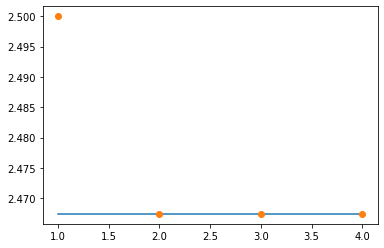

In [342]:
E_num = []
N_l = [1, 2, 3, 4]

#Compute numerical energies
for N in N_l:
    c = get_optimal_coefficients(N)
    wave_fn = lambda x: trial_wave(x, c, N)
    wave_fn_d2 = lambda x: trial_wave_d2(x, c, N)
    
    #Call energy computation function
    energy = compute_energy(wave_fn, wave_fn_d2)
    E_num.append(energy)
    
    print('Numerical Energy:', energy, 'Analytical Energy:', E)
    

plt.plot(N_l, [E] * 4, N_l, E_num, 'o')

The above observations agree with the statements above. There is a sharp increase in accuracy after increasing the N = 1 to N = 2, followed by incremental improvements on the trajectory to converge with the analytical value.